In [1]:
!pip install pytorch_lightning

In [2]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path(2)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['src', '.git', 'playground', 'setup', 'README.md', 'hf_wdf.sh', '.gitignore', 'freqnet_image.ipynb', 'config.py', 'reports', '__pycache__', 'faceforensics_download.py', 'environment.yml', 'run_jupyter.sh']


In [3]:
# import local config
import config

In [4]:
# from src.adapters.datasets.wilddeepfake import load_streaming_dataset
from datasets import load_dataset

In [5]:
import torch

In [6]:
import matplotlib.pyplot as plt

In [7]:
from src.transforms.frequency import dct_coeff

In [8]:
dataset = load_dataset("xingjunm/WildDeepfake", streaming=True, split="test")

Resolving data files:   0%|          | 0/963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

In [9]:
from tqdm import tqdm

In [10]:
real_index = 107003
sample_size = 500
ep = 50
skipped_dataset = dataset.skip(real_index - sample_size - ep)

In [11]:
import numpy as np

dct_mean_real = np.zeros((1, 224, 224))
dct_mean_fake = np.zeros((1, 224, 224))
real_count = 0
fake_count = 0
dct_real = None
dct_fake = None
pbar = tqdm(total=165662//2)


for d in skipped_dataset:
    img = d['png']
    dct_result = dct_coeff(img)  # Returns a NumPy array
    dct_result = dct_result.detach().cpu().numpy()


    if "real" in d["__key__"] and real_count<sample_size:
        real_count += 1
        dct_real = dct_result
        dct_mean_real += (dct_result - dct_mean_real) / real_count
    elif "fake" in d["__key__"] and fake_count<sample_size:
        fake_count += 1
        dct_fake = dct_result
        dct_mean_fake += (dct_result - dct_mean_fake) / fake_count
    if real_count >=sample_size and fake_count>=sample_size:
      break

    pbar.update(1)

  1%|▏         | 1036/82831 [03:36<17:18, 78.74it/s]

In [12]:
print("Real samples:", real_count)
print("Fake samples:", fake_count)

Real samples: 500
Fake samples: 500


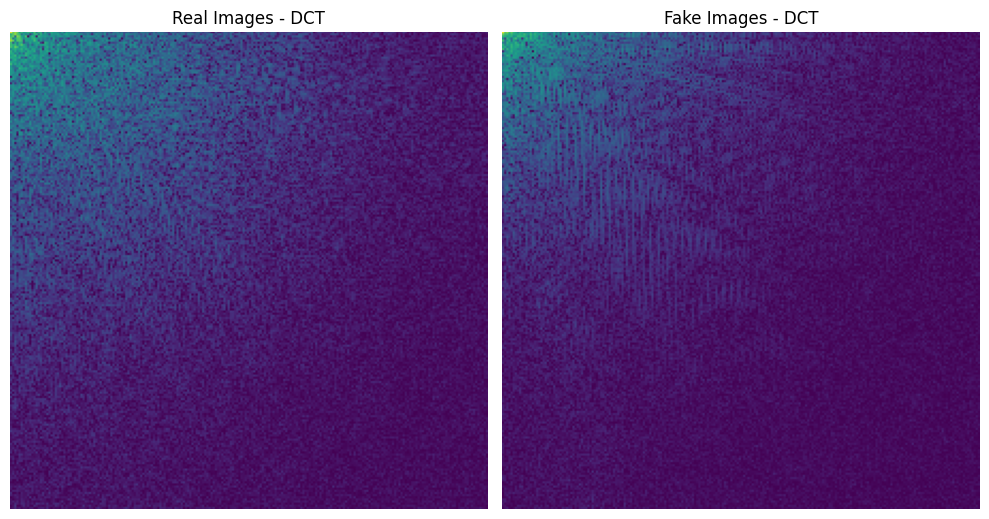

In [13]:
dct_real = np.squeeze(dct_real)
dct_fake = np.squeeze(dct_fake)

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(dct_real)
axs[0].set_title('Real Images - DCT')

axs[1].imshow(dct_fake)
axs[1].set_title('Fake Images - DCT')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
plt.savefig('dct_mean_real_fake.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>